In [6]:
from dataset.msc_sessions import MSC_Session
import os
import json
import pandas as pd
import numpy as np
import math
import itertools
from ast import literal_eval
import matplotlib.pyplot as plt
from tabulate import tabulate

In [7]:
# List the available files in the eval_results directory

eval_results_dir = "/Users/FrankVerhoef/Programming/PEX/output/eval_results/"
files = sorted([item.path for item in os.scandir(eval_results_dir) if not item.is_dir()])
files

['/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained_f_hpc_s4_dgpt_20230616_0334_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained_f_hpc_s4_dgpt_20230616_0334_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained_f_hpc_s4_dgpt_20230616_0443_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained_f_hpc_s4_dgpt_20230616_0443_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained_f_hpc_s4_dgpt_20230616_0511_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained_f_hpc_s4_dgpt_20230616_0511_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained_f_hpc_s4_dgpt_20230616_1159_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained_f_hpc_s4_dgpt_20230616_1159_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained_f_hpc_s4_dgpt_20230616_1255_evalresults.txt',
 '/Users/FrankVe

In [8]:
# Collect results in dicts
# stats_dict = {}
# evalresults_dict = {}
stats_list = []
evalresults_dict = {}
config_list = []
trial_names = list(set([
    '_'.join((f.split('/')[-1].split('_')[:-1]))
    for f in files
]))
for trial_name in trial_names:
    with open(f"{eval_results_dir}{trial_name}_stats.txt") as f:
        data = f.read().replace('\n', '')
        stats = json.loads(data.split('}{')[0] + '}')
        stats["trial_name"] = trial_name
        stats["date"] = '_'.join(trial_name.split('_')[-2:])
        config = json.loads('{' + data.split('}{')[1])
        config["trial_name"] = trial_name
        stats_list.append(stats)
        config_list.append(config)

    with open(f"{eval_results_dir}{trial_name}_evalresults.txt") as f:
        data = f.read().replace('\n', '')
        evalresults = json.loads(data.split('}{')[0] + '}')
        evalresults = {literal_eval(k): v for k, v in evalresults.items()}
        evalresults_dict[trial_name] = evalresults
    
# stats_dict[trial_names[0]]
print(len(stats_list), len(evalresults_dict), len(config_list))

43 43 43


In [9]:
# Convert list with stats and configs to dataframe

all_stats_df = pd.DataFrame.from_dict(stats_list)
all_stats_df = all_stats_df.set_index("trial_name")
all_config_df = pd.DataFrame(config_list)
all_config_df = all_config_df.set_index("trial_name")

In [10]:
# Combine stats with config

all_stats_df = all_stats_df.join(all_config_df, validate="1:1")

In [11]:
all_stats_df[(all_stats_df['date'] <'20230620')]['date']

trial_name
trained_hg_hpc_s4_dgpt_20230616_0350             20230616_0350
trained_f_hpc_s4_dgpt_20230616_1324              20230616_1324
trained_g_s4_dgpt_20230616_0037                  20230616_0037
trained_f_hpc_s4_dgpt_20230616_0443              20230616_0443
trained_hfb_hpc_s4_dgpt_20230616_151127        20230616_151127
trained_hb_hpc_s4_dgpt_20230616_151225         20230616_151225
trained_f_hpc_s4_dgpt_20230616_1159              20230616_1159
trained_f_hpc_s4_dgpt_20230616_1325              20230616_1325
trained_f_hpc_s4_dgpt_20230616_1301              20230616_1301
trained_f_hpc_s4_dgpt_20230616_1338              20230616_1338
trained_f_hpc_s4_dgpt_20230616_0511              20230616_0511
trained_hgb_hpc_s4_dgpt_20230616_151325        20230616_151325
trained_h_hpc_s4_dgpt_20230616_0350              20230616_0350
trained_hfb_tok_hpc_s4_dgpt_20230616_142903    20230616_142903
trained_f_hpc_s4_dgpt_20230616_1255              20230616_1255
trained_f_hpc_s4_dgpt_20230616_134116       

In [12]:
selection = (all_stats_df['input_order'] == 'history-personas-current') \
    & (all_stats_df['action'] == 'eval') \
    & (all_stats_df['persona_selector'].notnull()) \
    & (all_stats_df['date'] < '20230620')
df = all_stats_df[selection]
print("Number of trials in selection: ", len(df))
print("Trial names: ", df.index.values)
metrics = [c for c in df.columns if (c[:5] == 'test_' and c != 'test_samples') or (c[:5] == 'eval_')]
grouplist = ['session', 'include_history']
df[grouplist + metrics].sort_values(by=['session']) #.groupby(grouplist).mean()
# df[['date', 'load'] + grouplist + metrics].sort_values(by=['session', 'date'])

Number of trials in selection:  12
Trial names:  ['trained_f_hpc_s4_dgpt_20230616_1324'
 'trained_f_hpc_s4_dgpt_20230616_0443'
 'trained_f_hpc_s4_dgpt_20230616_1159'
 'trained_f_hpc_s4_dgpt_20230616_1325'
 'trained_f_hpc_s4_dgpt_20230616_1301'
 'trained_f_hpc_s4_dgpt_20230616_1338'
 'trained_f_hpc_s4_dgpt_20230616_0511'
 'trained_f_hpc_s4_dgpt_20230616_1255'
 'trained_f_hpc_s4_dgpt_20230616_134116'
 'trained_f_hpc_s4_dgpt_20230616_1320'
 'trained_f_hpc_s4_dgpt_20230616_1315'
 'trained_f_hpc_s4_dgpt_20230616_1313']


,session,include_history,test_loss,test_acc,test_perplexity,eval_truncation,eval_sacreblue_4,eval_bleu_2,eval_bleu_4,eval_bert_f1,eval_rougeL_fmeasure,eval_rougeL_precision,eval_rougeL_recall,eval_meteor,eval_google_bleu
trial_name,,,,,,,,,,,,,,,
trained_f_hpc_s4_dgpt_20230616_0443,1,False,2.955750,0.451844,19.217449,0.000000,0.026800,0.020933,0.003109,0.533000,0.165227,0.188046,0.163167,0.229053,0.086842
trained_f_hpc_s4_dgpt_20230616_1159,1,True,2.955750,0.451844,19.217449,0.000000,0.026800,0.020933,0.003109,0.533000,0.165227,0.188046,0.163167,0.229053,0.086842
trained_f_hpc_s4_dgpt_20230616_1325,1,False,2.953505,0.451989,19.174343,0.000000,0.027776,0.021669,0.003655,0.532668,0.166087,0.189362,0.163860,0.229253,0.087038
trained_f_hpc_s4_dgpt_20230616_1315,1,True,2.953505,0.451989,19.174343,0.000000,0.027776,0.021669,0.003655,0.532668,0.166087,0.189362,0.163860,0.229253,0.087038
trained_f_hpc_s4_dgpt_20230616_1255,2,True,2.526293,0.510733,12.507853,0.000256,0.027006,0.043139,0.007570,0.515574,0.157049,0.179190,0.161567,0.196189,0.071714
trained_f_hpc_s4_dgpt_20230616_1320,2,False,2.191304,0.551522,8.947381,0.000000,0.024996,0.041770,0.007144,0.519758,0.153263,0.180894,0.156349,0.197040,0.071549
trained_f_hpc_s4_dgpt_20230616_1324,3,False,2.071112,0.574106,7.934076,0.000022,0.026016,0.044585,0.007897,0.519919,0.154567,0.173426,0.163217,0.199270,0.071390
trained_f_hpc_s4_dgpt_20230616_134116,3,True,2.554204,0.488703,12.861911,0.086099,0.025298,0.044634,0.007686,0.512810,0.159548,0.187402,0.161463,0.192267,0.069937
trained_f_hpc_s4_dgpt_20230616_1338,4,False,1.992115,0.590904,7.331415,0.000127,0.026154,0.045816,0.007455,0.525122,0.158302,0.178707,0.165117,0.202947,0.072724


In [13]:
all_config_df.loc["trained_f_hpc_s4_dgpt_20230616_1338"]

configfile                                                 None
seed                                                         42
checkpoint_dir                                   ./checkpoints/
output_dir                                            ./output/
log_interval                                                  5
loglevel                                                VERBOSE
logdir                      /scratch-local/frankv.2927051/logs/
load                                      trained_f_hpc_s4_dgpt
save                                                           
device                                                     cuda
use_wandb                                                 False
action                                                     eval
model                                                  dialogpt
task                                                     dialog
experiment_name                                        trainpex
epochs                                  

Number of trials in selection:  12


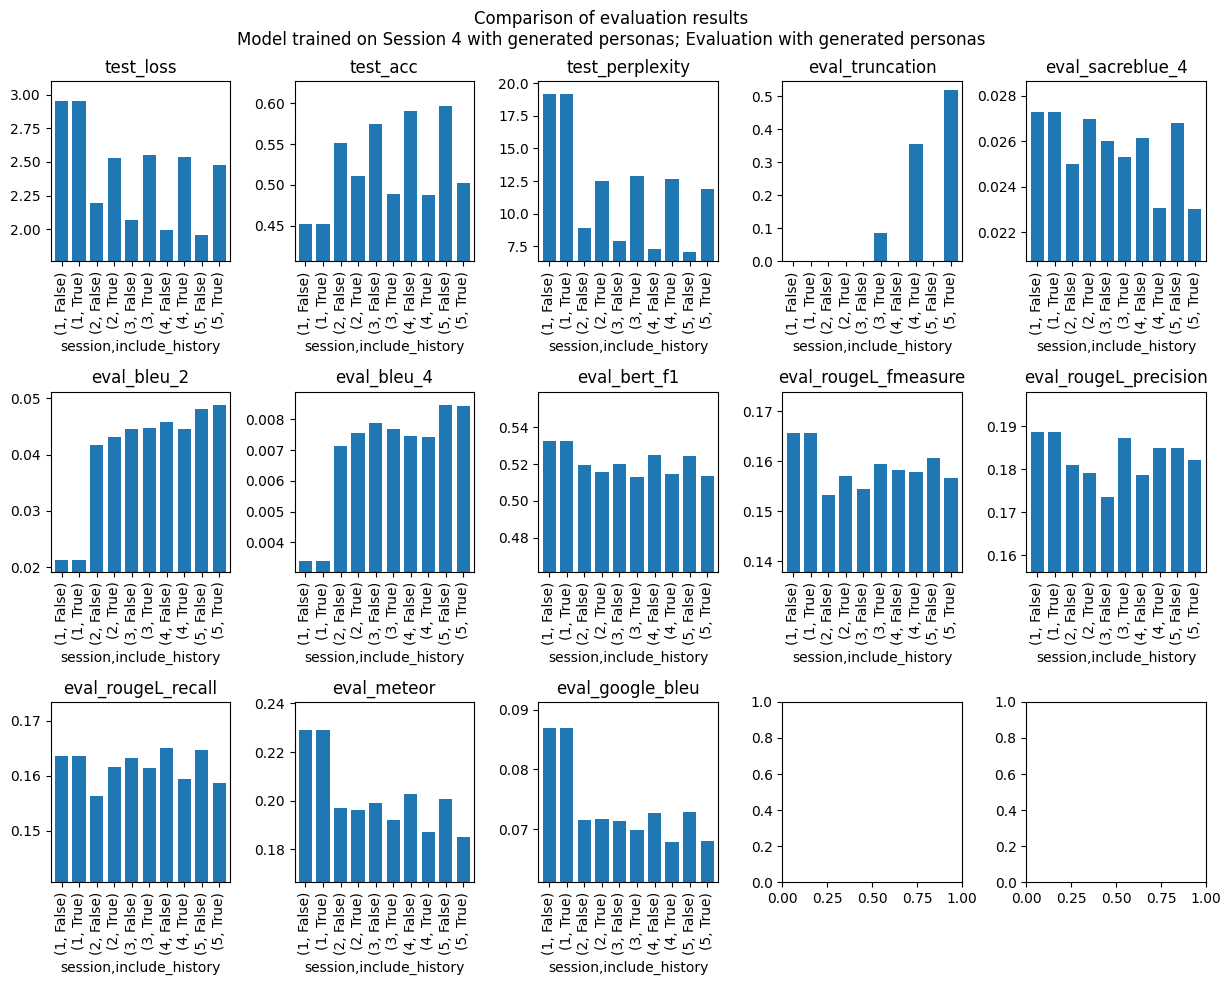

In [14]:
selection = (all_stats_df['input_order'] == 'history-personas-current') \
    & (all_stats_df['action'] == 'eval') \
    & (all_stats_df['persona_selector'].notnull()) \
    & (all_stats_df['date'] < '20230620')
print("Number of trials in selection: ", len(all_stats_df[selection]))

metrics = [c for c in all_stats_df.columns if (c[:5] == 'test_' and c != 'test_samples') or (c[:5] == 'eval_')]
grouplist = ['session', 'include_history']

df = all_stats_df[selection][grouplist + metrics].groupby(grouplist).mean()

fig, axs = plt.subplots(ncols=min(5, len(metrics)), nrows=1 + len(metrics) // 5, figsize=(2.5 * min(5, len(metrics)), 3 + 3 * len(metrics) // 5))

for metric, ax in zip(metrics, axs.flatten()):
    ax.set_title(metric)
    df[metric].plot.bar(ax=ax, width=0.75)
    # for i, v in zip(range(len(df[metric].index)), df[metric].values):
    #     ax.text(i, v*1.1, f"{v:.2f}", horizontalalignment='center', verticalalignment='center', fontsize='small', c='k', rotation=90)
    ax.set_ylim(df[metric].min()*0.9)

fig.suptitle("Comparison of evaluation results\nModel trained on Session 4 with generated personas; Evaluation with generated personas")
fig.tight_layout()

## Inspect results of individual dialogue samples

In [15]:
sessions = [1, 2, 3, 4, 5]
subset = 'test'
basedir = "/Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/"


In [16]:
session = 4
selection = \
    (all_stats_df['input_order'] == 'history-personas-current') \
    & (all_stats_df['action'] == 'eval') \
    & (all_stats_df['persona_selector'].notnull()) \
    & (all_stats_df['session'] == session)
print("Number of trials in selection: ", len(all_stats_df[selection]))

trial_names = all_stats_df[selection].index.values
metric = 'eval_bert_f1'
print(all_stats_df[selection][metric])

evalresults = evalresults_dict["trained_f_hpc_s4_dgpt_20230620_012246"]
print(len(evalresults))

keys = list(evalresults.keys())
values = list(evalresults.values())
eval_df = pd.DataFrame.from_records(values, index=keys)


Number of trials in selection:  8
trial_name
trained_f_hpc_s4_dgpt_20230620_013400    0.556993
trained_f_hpc_s4_dgpt_20230620_012153    0.558622
trained_f_hpc_s4_dgpt_20230616_1338      0.525122
trained_f_hpc_s4_dgpt_20230620_014031    0.542050
trained_f_hpc_s4_dgpt_20230620_013212    0.555224
trained_f_hpc_s4_dgpt_20230620_012246    0.558713
trained_f_hpc_s4_dgpt_20230620_014212    0.551617
trained_f_hpc_s4_dgpt_20230616_1313      0.514740
Name: eval_bert_f1, dtype: float64
5940


In [17]:
msc_session_config = [c for c in config_list if c['trial_name'] == "trained_f_hpc_s4_dgpt_20230620_013212"][0]
msc_session_config
MSC_Session.set(speaker_prefixes=msc_session_config['speaker_prefixes'], sessionbreak_token='<session>') #msc_session_config['sessionbreak_token'])
msc_session = MSC_Session(
    basedir=basedir, 
    session=msc_session_config['session'], 
    subset='test', 
    include_history=msc_session_config['include_history'],
    include_persona=msc_session_config['include_persona'],
    persona_selector=msc_session_config['persona_selector'],
    augmented=msc_session_config['augmented']
)

2023-06-23 20:10:18,905 INFO     | Read 501 dialogues from MSC session 4 for test dataset
2023-06-23 20:10:18,906 INFO     | Loading preprocessed summaries from: /Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/preprocessed:trained_base_reweighted_bart:session_4_test.json


In [18]:
print(msc_session[1][0])

<session>personas
<self>I am a meat eater.
<self>I like running.
<self>I wear pants.
<self>My parents grew up in alaska.
<self>I work as a programmer.
<self>I live in a small town. I enjoy walking and running.
<self>I am a computer programmer.
<self>I love meat. I grill.
<self>I am from Alaska.
<self>I love wearing warm pants.
<self>I am considering joining the local gym.
<self>I hate to run when its raining.
<self>I am considering getting a treadmill.
<self>I live in a small town.
<self>I like running trails.
<self>I am interested in running.
<self>I like the gym in town.
<self>I am plain.
<self>I like to use a treadmill.
<self>I like the idea of an inside option.
<self>I live in a place where there are four seasons.
<self>I live in the tropics. I like the weather.
<other>I like going to the gym.
<other>I work in marketing.
<other>I don't eat meat.
<other>I live in New England.
<other>I love wearing warm pants in the winter.
<other>I like the controlled environment. I live in a city.


In [19]:
highest_bert = eval_df.sort_values(by=['bert_f1'], ascending=False).head(10)
print(f"Bert-score best-10: {highest_bert['bert_f1'].mean():.2f}")

for index, row in highest_bert.iterrows():

    index = index
    i = msc_session.find(dialog_id=index[1], turn_id=index[2])
    if i >= 0:
        history = msc_session[i][0]
        last_utterance = history[:-1].split('\n')[-1]
    else:
        last_utterance = f'WARNING: dialogue not found {index}'
    print(f"Index          : dialog {index[1]:4}  turn {index[2]}")
    print(f"Truncation     : {row['input_truncation']:.0%}")
    print(f"Bert-score     : f1 {row['bert_f1']:.4f}   precision {row['bert_precision']:.4f}   recall {row['bert_recall']:.4f}")
    print(f"Last utterance : {last_utterance}")
    print(f"Target         : {row['target_response'][:-1]}")
    print(f"Prediction     : {row['pred_response'][:-1]}")
    print('-' * 40)

Bert-score best-10: 0.79
Index          : dialog   28  turn 5
Truncation     : 0%
Bert-score     : f1 0.8482   precision 0.9619   recall 0.7586
Last utterance : <other>And you have made so much money. That really is incredible! You inspired me to start walking a bit more. Sometimes the kids join me, but I really do love the solitude when I go alone.
Target         : <self>I'm not sure I could handle a walk with kids. What else do you guys do for outdoor fun?
Prediction     : <self>I love the quietness of the neighborhood. It's so nice to be able to walk around the neighborhood.
----------------------------------------
Index          : dialog  114  turn 0
Truncation     : 0%
Bert-score     : f1 0.8280   precision 0.8886   recall 0.7752
Last utterance : <session>new session
Target         : <self>Where do you think you would want to move to if you leave Hawaii?
Prediction     : <self>I have a job
----------------------------------------
Index          : dialog   38  turn 3
Truncation    

In [20]:
lowest_bert = eval_df.sort_values(by=['bert_f1'], ascending=True).head(10)
print(f"Bert-score best-10: {lowest_bert['bert_f1'].mean():.2f}")

for index, row in lowest_bert.iterrows():

    index = index
    i = msc_session.find(dialog_id=index[1], turn_id=index[2])
    if i >= 0:
        history = msc_session[i][0]
        last_utterance = history[:-1].split('\n')[-1]
    else:
        last_utterance = f'WARNING: dialogue not found {index}'
    print(f"Index          : dialog {index[1]:4}  turn {index[2]}")
    print(f"Truncation     : {row['input_truncation']:.0%}")
    print(f"Bert-score     : f1 {row['bert_f1']:.4f}   precision {row['bert_precision']:.4f}   recall {row['bert_recall']:.4f}")
    print(f"Last utterance : {last_utterance}")
    print(f"Target         : {row['target_response'][:-1]}")
    print(f"Prediction     : {row['pred_response'][:-1]}")
    print('-' * 40)

Bert-score best-10: 0.42
Index          : dialog  419  turn 3
Truncation     : 0%
Bert-score     : f1 0.4081   precision 0.4243   recall 0.3931
Last utterance : <other>We are still researching but if you have any suggestions, please pass them along! 
Target         : <self>Discovery Park is nice. I was just there with a friend this past weekend. It's not super challenging, though.
Prediction     : <self>That would be great! I'm sure you will enjoy it!
----------------------------------------
Index          : dialog  118  turn 1
Truncation     : 0%
Bert-score     : f1 0.4094   precision 0.4381   recall 0.3842
Last utterance : <other>How are the linguistic studies going?
Target         : <self>They are going well and so are my other classes!  its been busy.  I cant imagine what a computer science major is like, lol
Prediction     : <self>I am going to have to learn how to read
----------------------------------------
Index          : dialog  196  turn 7
Truncation     : 0%
Bert-score    

## Inspect output from various decoder options

In [79]:
# collect results from the relevant trials in a dataframe 'results_df'

selection = (all_stats_df['date'] > '20230619')
decoder_options = ['do_sample', 'num_beams', 'temperature', 'top_p', 'top_k']
result_df = all_stats_df[selection][['session'] + decoder_options + metrics]
result_df['num_beams'] = result_df['num_beams'].astype(int)
result_df['top_k'] = result_df['top_k'].astype(int)
result_df = result_df.sort_values(by=['do_sample', 'num_beams', 'top_k', 'temperature'])
result_df


,session,do_sample,num_beams,temperature,top_p,top_k,test_loss,test_acc,test_perplexity,eval_truncation,eval_sacreblue_4,eval_bleu_2,eval_bleu_4,eval_bert_f1,eval_rougeL_fmeasure,eval_rougeL_precision,eval_rougeL_recall,eval_meteor,eval_google_bleu
trial_name,,,,,,,,,,,,,,,,,,,
trained_f_hpc_s4_dgpt_20230620_235143,5,False,1,1.0,1.0,50,1.954918,0.596901,7.063718,0.001679,0.048885,0.032658,0.006574,0.549828,0.187226,0.235898,0.172584,0.240406,0.089826
trained_f_hpc_s4_dgpt_20230620_014212,4,False,1,1.0,1.0,50,1.992115,0.590904,7.331415,0.000127,0.050797,0.032487,0.006237,0.551617,0.185544,0.230659,0.174058,0.243494,0.090761
trained_f_hpc_s4_dgpt_20230620_235609,5,True,1,1.0,1.0,50,1.954918,0.596901,7.063718,0.001679,0.038183,0.025951,0.002953,0.540353,0.158831,0.197708,0.150697,0.233593,0.082197
trained_f_hpc_s4_dgpt_20230620_014031,4,True,1,1.0,1.0,50,NaN,0.590871,NaN,0.000127,0.040304,0.026327,0.002828,0.542050,0.159277,0.193457,0.154206,0.238954,0.084176
trained_f_hpc_s4_dgpt_20230620_012153,4,True,5,1.0,0.9,10,1.992115,0.590904,7.331415,0.000127,0.045330,0.027419,0.006109,0.558622,0.192206,0.280246,0.162171,0.244764,0.091657
trained_f_hpc_s4_dgpt_20230623_150452,5,True,5,1.0,0.9,10,1.954918,0.596901,7.063718,0.001679,0.043922,0.026721,0.006316,0.555741,0.194585,0.291277,0.161430,0.241740,0.090673
trained_f_hpc_s4_dgpt_20230620_013400,4,True,5,0.5,0.9,50,1.992115,0.590904,7.331415,0.000127,0.046610,0.027393,0.006229,0.556993,0.191604,0.269027,0.165032,0.242307,0.090718
trained_f_hpc_s4_dgpt_20230621_001220,5,True,5,0.5,0.9,50,1.954918,0.596901,7.063718,0.001679,0.044493,0.026904,0.006073,0.555083,0.193046,0.277913,0.163537,0.239399,0.089411
trained_f_hpc_s4_dgpt_20230621_000915,5,True,5,1.0,0.9,50,1.954918,0.596901,7.063718,0.001679,0.043597,0.026736,0.006285,0.555076,0.191812,0.286753,0.159728,0.240633,0.090523


### Generate plot with the metrics

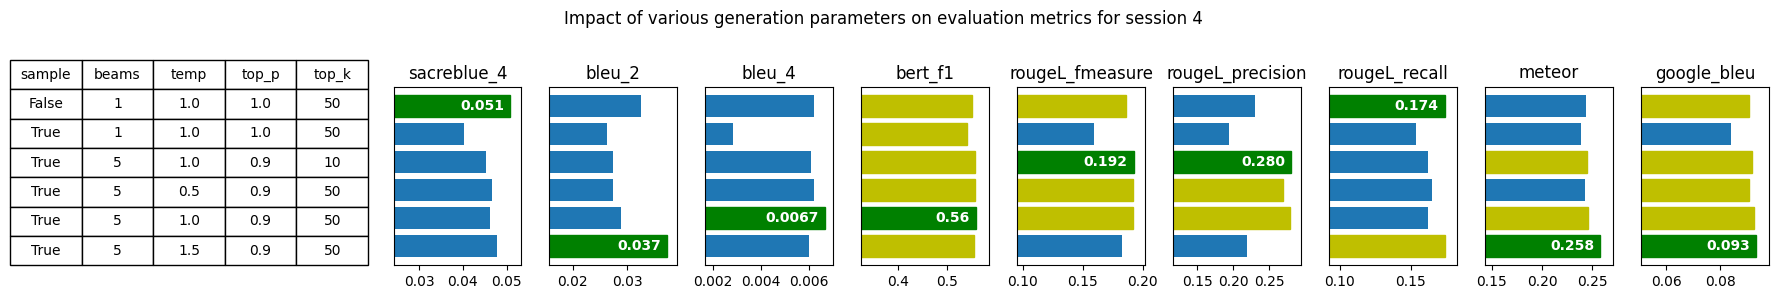

In [81]:
# Make subselection for one session
session = 4
subselection = result_df['session'] == session

# Define metrics to show
eval_metrics = [m for m in metrics if m[:4] == 'eval' and m != 'eval_truncation']

# Define figure format
fig, axs = plt.subplots(ncols=len(eval_metrics), figsize=(2 * len(eval_metrics), 3), sharey=True)

# Loopt over metrics to plot bar charts
for m, ax in zip(eval_metrics, axs):

    # Plot bar chart
    ax_bar = ax.barh(y=list(range(len(result_df[subselection]))), width=result_df[subselection][m][::-1])

    # Print value in tha max bar, and color the bars
    max_value = result_df[subselection][m].max()
    x_min = result_df[subselection][m].min() * 0.6
    xticks = ax.get_xticks()
    digits = math.ceil(-math.log10((xticks[-1] - xticks[0])/len(xticks)))+1
    for i, v in enumerate(result_df[subselection][m][::-1]):
        if v == max_value:
            ax_bar[i].set_color('g')
            ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
        elif v > 0.95 * max_value:
            ax_bar[i].set_color('y')
    
    # Add title, other formatting
    ax.set_title(m[5:])
    ax.set_xlim(x_min)

# Remove labels n left side (to make room for the table)
axs[0].set_yticks([])
axs[0].set_yticklabels([])

# Plot a table with the parameters of the generation config
# NOTE: Table items are in reversed order compared to bars !!
ax_table = axs[0].table(cellText=result_df[subselection][decoder_options].values,
    colLabels=[o if len(o) < 8 else (o[:4] if (o.find('_') < 0) else o.split('_')[1]) for o in decoder_options],
    cellLoc='center',
    bbox=[-3, 0, 2.8, 1.15],
)
ax_table.auto_set_font_size(False)
ax_table.set_fontsize(10)

# Main title for the figure
fig.suptitle(f"Impact of various generation parameters on evaluation metrics for session {session}")
fig.tight_layout()

### Print predictions for one dialogue, for different generation configs

In [76]:
# Get the config for one of the trials in the selection
session = 4
subselection = result_df['session'] == session
trial_names = result_df[subselection].index.values
print(trial_names)
msc_session_config = [c for c in config_list if c['trial_name'] == trial_names[0]][0]
msc_session_config

['trained_f_hpc_s4_dgpt_20230620_014212'
 'trained_f_hpc_s4_dgpt_20230620_014031'
 'trained_f_hpc_s4_dgpt_20230620_012153'
 'trained_f_hpc_s4_dgpt_20230620_013400'
 'trained_f_hpc_s4_dgpt_20230620_012246'
 'trained_f_hpc_s4_dgpt_20230620_013212']


{'configfile': None,
 'seed': 42,
 'checkpoint_dir': './checkpoints/',
 'output_dir': './output/',
 'log_interval': 5,
 'loglevel': 'VERBOSE',
 'logdir': '/scratch-local/frankv.2942488/logs/',
 'load': 'trained_f_hpc_s4_dgpt',
 'save': '',
 'device': 'cuda',
 'use_wandb': False,
 'action': 'eval',
 'model': 'dialogpt',
 'task': 'dialog',
 'experiment_name': 'trainpex',
 'epochs': 1,
 'learning_rate': 0.001,
 'valid_interval': None,
 'patience': None,
 'batch_size': 8,
 'skip_eval': False,
 'metrics': None,
 'print_max': 20,
 'temperature': 1.0,
 'top_p': 1.0,
 'top_k': 50,
 'do_sample': False,
 'num_beams': 1,
 'lm': 'gpt2',
 'decoder_max': 30,
 'datadir': '/scratch-local/frankv.2942488/data/',
 'basedir': 'msc/msc_dialogue/',
 'train_samples': None,
 'valid_samples': None,
 'test_samples': None,
 'speaker_prefixes': ['<other>', '<self>'],
 'add_tokens': None,
 'include_persona': True,
 'include_history': False,
 'input_order': 'history-personas-current',
 'sessionbreak_token': None,
 

In [77]:
MSC_Session.set(speaker_prefixes=msc_session_config['speaker_prefixes'], sessionbreak_token='<session>') #msc_session_config['sessionbreak_token'])
msc_session = MSC_Session(
    basedir="/Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/",
    session=session, 
    subset='test', 
    include_history=msc_session_config['include_history'],
    include_persona=msc_session_config['include_persona'],
    persona_selector=msc_session_config['persona_selector'],
    augmented=msc_session_config['augmented']
)

2023-06-23 21:41:35,910 INFO     | Read 501 dialogues from MSC session 4 for test dataset
2023-06-23 21:41:35,911 INFO     | Loading preprocessed summaries from: /Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/preprocessed:trained_base_reweighted_bart:session_4_test.json


In [78]:
dialog_id = 1
turn_id = 4
i = msc_session.find(dialog_id=dialog_id, turn_id=turn_id)
df = result_df[subselection][decoder_options]
df['pred_response'] = [evalresults_dict[t][session, dialog_id, turn_id]['pred_response'] for t in df.index]

print("History:")
print(msc_session[i][0])
print("Target:")
print(msc_session[i][1])

print(tabulate(df.sort_values(by=['do_sample', 'num_beams', 'top_k', 'temperature']), headers='keys', tablefmt='outline', showindex=False))


History:
<session>personas
<self>I am girl.
<self>I am a young girl who is still in highschool.
<self>I enjoy marching band in the fall and concert band in the season.
<self>My parents are both teachers.
<self>My favorite subject is english.
<self>I play band in school.
<self>I play for my high school.
<self>I play the trumpet.
<self>I have lived in Oklahoma City for my whole life.
<self>I have a lot of school. I have never been to a concert.
<self>I work on music for a while.
<self>I have never been to a concert.
<self>I am nervous to go to a concert.
<self>I avoid crowds.
<self>I need someone to go with me.
<self>I am shy.
<self>I like to go to concerts.
<other>I drove 1,000 miles to see my favorite band play.
<other>I have 2 older brothers. I like Roxy music.
<other>I am from meself.
<other>I just moved to Charlotte, NC.
<other>I saw a concert by a trumpet player.
<other>I have been to see bands since I was a kid.
<other>I wish I could've pursued my dreams of music when I was in hig